# Custom networks

A simple dense neural network can be written using a container network like `Sequence`. This is valid, concise and useful. Still, this does not allow a lot of customization, other than changing various parameters for different layers. Even if it involves a little bit more work, there is another way to create custom networks which brings more floxibility. This is the purpose of this tutorial.

In [41]:
%load ../../rapaio-bootstrap.ipynb

Adding dependency io.github.padreati:rapaio-lib:7.0.1
Solving dependencies
Resolved artifacts count: 1
Add to classpath: /home/ati/work/rapaio-jupyter-kernel/target/mima_cache/io/github/padreati/rapaio-lib/7.0.1/rapaio-lib-7.0.1.jar


In order to setup the thigs we need a problem. A simple problem to let us concentrate our attention on the central topic. For that we will use the well-known advertising dataset, from ISLR book.

In [42]:
// first step is to create a tensor manager
TensorManager tm = TensorManager.ofFloat();
tm.seed(42);

In [43]:
// and get the dataset
Frame df = Datasets.loadISLAdvertising();
df.printSummary();

Frame Summary
* rowCount: 200
* complete: 200/200
* varCount: 4
* varNames: 

0.        TV : dbl | 
1.     Radio : dbl | 
2. Newspaper : dbl | 
3.     Sales : dbl | 

* summary: 
       TV [dbl]           Radio [dbl]       Newspaper [dbl]           Sales [dbl]      
   Min. :   0.7000000    Min. :  0.0000000     Min. :   0.3000000    Min. :  1.6000000 
1st Qu. :  74.3750000 1st Qu. :  9.9750000  1st Qu. :  12.7500000 1st Qu. : 10.3750000 
 Median : 149.7500000  Median : 22.9000000   Median :  25.7500000  Median : 12.9000000 
   Mean : 147.0425000    Mean : 23.2640000     Mean :  30.5540000    Mean : 14.0225000 
2nd Qu. : 218.8250000 2nd Qu. : 36.5250000  2nd Qu. :  45.1000000 2nd Qu. : 17.4000000 
   Max. : 296.4000000    Max. : 49.6000000     Max. : 114.0000000    Max. : 27.0000000 
                                                                                       



As can be seen is a very simple regression problem, three input features, nothing fancy. We get also a tensor dataset for training and testing.

In [30]:
DArray<?> x = df.mapVars("TV", "Radio", "Newspaper").darray().cast(tm.dt());
DArray<?> y = df.mapVars("Sales").darray().cast(tm.dt());

In [32]:
TabularDataset ds = new TabularDataset(tm, x, y);
TabularDataset[] split = ds.trainTestSplit(0.2);
TabularDataset train = split[0];
TabularDataset test = split[1];

In [44]:
VarDouble trainLoss = VarDouble.empty().name("trainLoss");
VarDouble testLoss = VarDouble.empty().name("testLoss");
// mean squared error for a regression problem
Loss loss = new MSELoss(tm);

We can continue continue with a `Sequence` which can have some standard dense neural network layers, which would be fine. But we can also create the `Network` by itself. In `rapaio` the network, which has to implement `Network` interface is a recursive component. Networks can act by themself and can be used in another networks, which also can be used in another networks as layers, and so on. 

In order to create a network, the most direct way is to derive from `AbstractNetwork`.

In [47]:
class AdvertisingNetwork extends AbstractNetwork {
    final LayerNorm norm1;
    final Linear linear1;
    final ELU act1;
    final Linear linear2;
    final ELU act2;
    static final int hidden = 12;

    public AdvertisingNetwork(TensorManager tm) {
        super(tm);
        norm1 = new LayerNorm(tm, Shape.of(3));
        linear1 = new Linear(tm, 3, hidden, true);
        act1 = new ELU(tm);
        linear2 = new Linear(tm, hidden, 1, true);
        act2 = new ELU(tm);
    }

    // This does not need to be implemented in this case
    @Override
    public List<Tensor> parameters() {
        List<Tensor> params = new ArrayList<>();
        params.addAll(norm1.parameters());
        params.addAll(linear1.parameters());
        params.addAll(act1.parameters());
        params.addAll(linear2.parameters());
        params.addAll(act2.parameters());
        return params;
    }

    // This does not need to be implemented in this case
    @Override
    public NetworkState state() {
        NetworkState state = new NetworkState();
        state.merge(norm1.state());
        state.merge(linear1.state());
        state.merge(act1.state());
        state.merge(linear2.state());
        state.merge(act2.state());
        return state;
    }

    public Tensor forward11(Tensor x) {
        x = x.add(1).log();
        x = norm1.forward11(x);
        x = linear1.forward11(x);
        x = act1.forward11(x);
        x = linear2.forward11(x);
        x = act2.forward11(x);
        return x;
    }
}

The previous code needs a larger explanation. There are three main components which needs you attention when you implement your own network: parameters, network state and forward method. Those three components deals with three behaviors a network must provide.

## Custom network components

### Network parameters

A network parameter is a tensor which is optimized during learning. In other words it is the part of the network which changes during learning. Actually those are the things the network *learns* during training. 

Since the optimization part is delegated to some strategy which implements `Optimizer`, any network which is in process of training, needs to tell to that strategy which tensors to optimize. The standard terminology is to call those tensors parameters, so we follow that closely. 

There is a comment in before the method implementation which let us know that we don't need to implement that method in this case. This is true, but we implemented here for illustrative purposes. The reason why in this case the implementation of parameters is not required is given by the default implementation of this method. The default implementation uses reflection and searches for all members of out custom model which implements `Network` interface and collects recursively all their parameters. Basically what our implementation does, but using reflection. Since all our layers, which are also networks, are declared as field members of our custom class, the generic implementation should perform well and we do not need to implement that behaviour now.

### Network state

A network can be serialized on a persistent storage and later loaded from a persistent storage and use it for inference or even further training. In `rapaio` we do not save the network class in itself. This is because we want to be consistent with all the custom constructors and custom code when a network is created. For that reason storing and loading from a persistent storage is not done on the class code, but on all the values of the variables which determines the behavior of the network. We call this *network state*.

`NetworkState` is a container which contains all those variables which determines the behavior of a network. Thus when we recreate an instance of a network using its normal constructor code and load its state from a persistent storage, that new instance will behave precisely like the opriginal instance.

This method needs to capture recursively the network state from all their components. In a similar fashion as with the parameters, we notice a comment which let us know that for this case the implementation is not needed. This is also true here because of its default implementation, which uses reflection to collect and merge all network states from all the members of the class which implements `Network`. If there are additional things which are not covered by the default scenario, we need a custom implementation to handle this case.

### Network forward method

Network forward method contains the code which the network performs to do the forward step from backpropagation algorithm. It is the same step which is performed by a network to do inference. Thus, forward method describes in code the way how the network process input tensors to obtain output tensors. 

There are two forward methods described in the `Network` interface. The generic one called `Tensor[] forward(Tensor... inputs)`, receives an array of tensors which are the inputs and produces another array of tensors which are the inference results or outputs. This method allows one to consider any number of inputs and any number of outputs. 

The default implementation of `forward`, delegates its behavior to `Tensor forward11(Tensor x)`. This method is a special case of the previous method and takes a single input tensor and produces a single output tensor. Since this is the most encountered scenario for inference it was decribed as a separate method. 

For brevity, we removed the custom implementations of parameters and network state to see better the custom code.

In [48]:
class AdvertisingNetwork extends AbstractNetwork {
    final LayerNorm norm1;
    final Linear linear1;
    final ELU act1;
    final Linear linear2;
    final ELU act2;
    static final int hidden = 12;

    public AdvertisingNetwork(TensorManager tm) {
        super(tm);
        norm1 = new LayerNorm(tm, Shape.of(3));
        linear1 = new Linear(tm, 3, hidden, true);
        act1 = new ELU(tm);
        linear2 = new Linear(tm, hidden, 1, true);
        act2 = new ELU(tm);
    }
    public Tensor forward11(Tensor x) {
        x = x.add(1).log();
        x = norm1.forward11(x);
        x = linear1.forward11(x);
        x = act1.forward11(x);
        x = linear2.forward11(x);
        x = act2.forward11(x);
        return x;
    }
}

## Why a custom network?

A natural question can arise, which is why the hell to write a custom network code, since the default behavior is enough. The answer is that the default behavior you get by using containers and layers is not always enough. 

If you look closely at `forward11` method implementation you will see the first line which is `x = x.add(1).log()`. This line adds `1` to inputs and applies logarithm on those. This is not something which can be done with layers. Or at least you need a custom layer to implement that operation, which takes the same effort as the displayed implementation. Other things can also be done, which is basically almost any Java code. The only constraint is that if any calculus impacts the learning computation chain and it needs derivative computation, it must be done through tensor operations. 

Anything else is handled well. For illustrative purposes we can think of some scenarios which can be implemented using custom networks:

* suppose one has a variable length input, it can handle that through code in forward method
* collecting some statistics regarding values in the computed tensors, statistics which does not affect learning, but allows one to get a better insight on the learning process
* changing some parameter dinamically (like learning rate of the optimizer, for example)

Many other scenarios are possible, only the imagination is the limit. Things will work well as long as computing is done through tensors.

## Running out custom network

Below we use our custom created network, we do training and testing as usual.

In [49]:
int epochs = 200;
double lr = 1e-3;

In [50]:
Network nn = new AdvertisingNetwork(tm);
Optimizer optimizer = Optimizer.Adam(tm, nn.parameters()).lr.set(lr);

In [51]:
for (int i = 0; i < epochs; i++) {

    optimizer.zeroGrad();
    nn.train();

    int batchCount = 0;
    double trainLossValue = 0;
    Iterator<Batch> batchIterator = train.batchIterator(10, true, false);
    while (batchIterator.hasNext()) {
        Batch batch = batchIterator.next();
        Tensor pred = nn.forward11(batch.tensor(0));
        Loss.Output lossOut = loss.forward(pred, batch.tensor(1));

        trainLossValue += lossOut.lossValue();
        batchCount++;

        Autograd.backward(lossOut.tensor());
        optimizer.step();
    }

    trainLossValue /= batchCount;
    trainLoss.addDouble(trainLossValue);

    nn.eval();
    Tensor pred = nn.forward11(test.tensor(0));
    Loss.Output lossOut = loss.forward(pred, test.tensor(1));
    double testLossValue = lossOut.lossValue();
    testLoss.addDouble(testLossValue);

    if (i % 10 == 0) {
        printf("epoch %d, train loss: %.3f, test loss: %.3f%n", i, trainLossValue, testLossValue);
    }
}

epoch 0, train loss: 2163.835, test loss: 10302.107
epoch 10, train loss: 1729.624, test loss: 8233.459
epoch 20, train loss: 1022.213, test loss: 4899.007
epoch 30, train loss: 517.155, test loss: 2457.991
epoch 40, train loss: 452.038, test loss: 2124.178
epoch 50, train loss: 419.682, test loss: 2160.812
epoch 60, train loss: 427.569, test loss: 2151.771
epoch 70, train loss: 408.787, test loss: 2105.669
epoch 80, train loss: 385.598, test loss: 1985.541
epoch 90, train loss: 333.357, test loss: 1781.508
epoch 100, train loss: 305.792, test loss: 1614.575
epoch 110, train loss: 287.768, test loss: 1488.391
epoch 120, train loss: 270.393, test loss: 1468.078
epoch 130, train loss: 266.784, test loss: 1393.898
epoch 140, train loss: 266.476, test loss: 1410.740
epoch 150, train loss: 262.315, test loss: 1377.406
epoch 160, train loss: 259.111, test loss: 1351.840
epoch 170, train loss: 258.878, test loss: 1327.265
epoch 180, train loss: 258.344, test loss: 1340.381
epoch 190, train lo

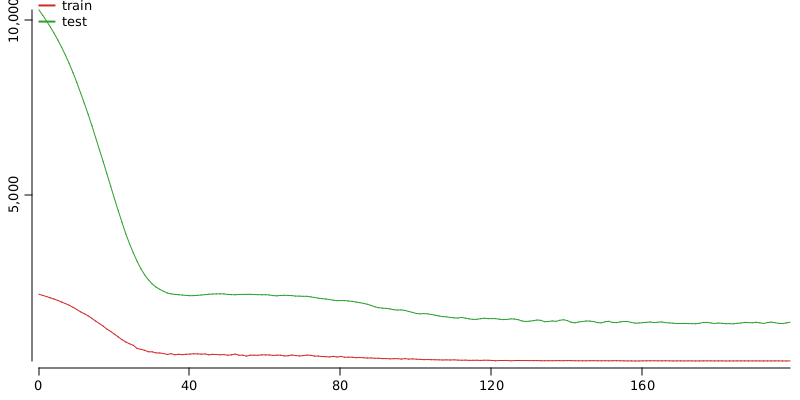

In [52]:
WS.image(Plotter.lines(trainLoss, color(1)).lines(testLoss, color(2)).legend(Legend.UP_LEFT, labels("train", "test")), 800, 400);

## Conclusion

Wrting custom networks is not complicated and pays the price in flexibility you gain while experimenting, training, and for other purposes. Take care about the three components of a network, which needs to be implemented. If you follow a standard architecture where you declare as field members all the layers you use in inference, you need only to write custom code for forward method. This flexibility is a main driver in fast iteration and experimentation which is omnipresent in the first stages of a network architecture development, while not loosing any performance of level of quality in the code.